In [59]:
# Preamble: load packages
import Pkg;

Pkg.add([
    "CairoMakie",
    "VoronoiCells",
    "Images",
    "GeometryBasics",
    "ProgressMeter",
])
using CairoMakie
using VoronoiCells, GeometryBasics
using Images, Random
using ProgressMeter

Pkg.Types.PkgError: The following package names could not be resolved:
 * Threads (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mT[22m[0m[1mh[22m[0m[1mr[22m[0m[1me[22m[0m[1ma[22m[0m[1md[22m[0m[1ms[22mX [0m[1mT[22m[0m[1mh[22m[0m[1mr[22m[0m[1me[22m[0m[1ma[22m[0m[1md[22m[0m[1mS[22mafeDicts [0m[1mT[22m[0m[1mh[22m[0m[1mr[22m[0m[1me[22m[0m[1ma[22m[0m[1md[22med[0m[1mS[22mcans [0m[1mT[22m[0m[1mh[22m[0m[1mr[22m[0m[1me[22m[0m[1ma[22m[0m[1md[22med[0m[1mS[22mparseCSR

In [2]:
function area(polygon)
    A = 0.0
    j = length(polygon)
    for i in eachindex(polygon)
        x1,y1 = polygon[i]
        x2,y2 = polygon[j]

        A += x1*y2
        A -= y1*x2
        j = i
    end

    return A / 2
end

function centroid(polygon)
    A = 0.0
    c_x = 0.0
    c_y = 0.0

    j = length(polygon)
    for i in eachindex(polygon) 
        x1,y1 = polygon[i]
        x2,y2 = polygon[j]

        det = x1 * y2 - x2 * y1        
        A += det
        c_x += (x1 + x2) * det
        c_y += (y1 + y2) * det

        j = i
    end
    A /= 2
    return Point2([c_x, c_y] / 6A)
end

centroid (generic function with 1 method)

In [3]:
# Quick voronoi demo

# Bounding box
bbox = Rectangle(Point2(0,0), Point2(1,1))

# 10 random 2D points
Random.seed!(24)
points = Point2.(eachcol(rand(2, 10)))

# Tesselate and get the center of each cell
voro_tess = voronoicells(points, bbox)
centroids = centroid.(voro_tess.Cells);

In [4]:
# Plot the points, the centroids and the voronoi cells
function plot(points, centers, polys)
    fig, ax, scat_plot = scatter(points, color=:red, label="Point")
    cent_plot = scatter!(ax, centers, color=:blue, label="Center")
    poly_lines = nothing
    for poly in polys
        poly_lines = poly!(ax, poly, color=:transparent, strokewidth=1, srokecolor=:blue)
    end
    
    Legend(fig[1, 2], [scat_plot, cent_plot, poly_lines], ["Point", "Centroid", "Voronoi Cell"])
    hidedecorations!(ax)
    hidespines!(ax)
    return Makie.FigureAxisPlot(fig,ax,scat_plot)
end;

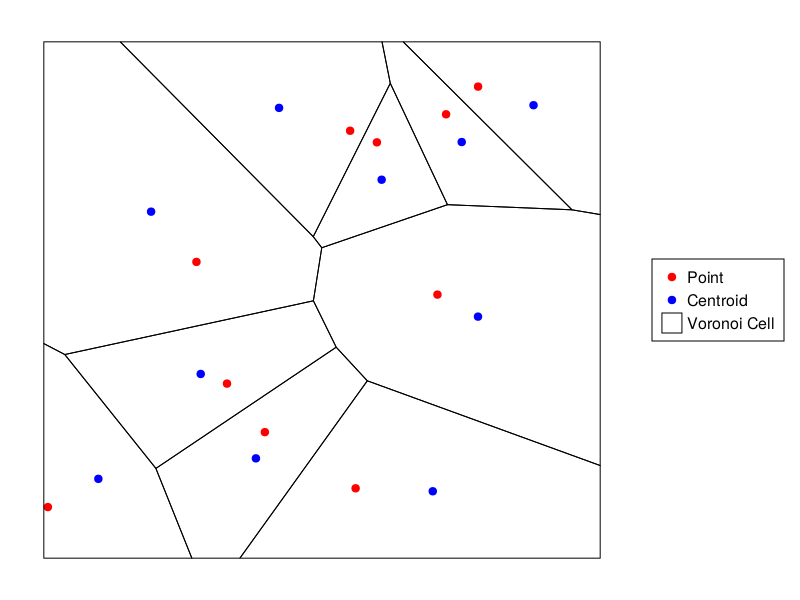

In [5]:
polys = Polygon.(voro_tess.Cells)
plot(points, centroids, polys)

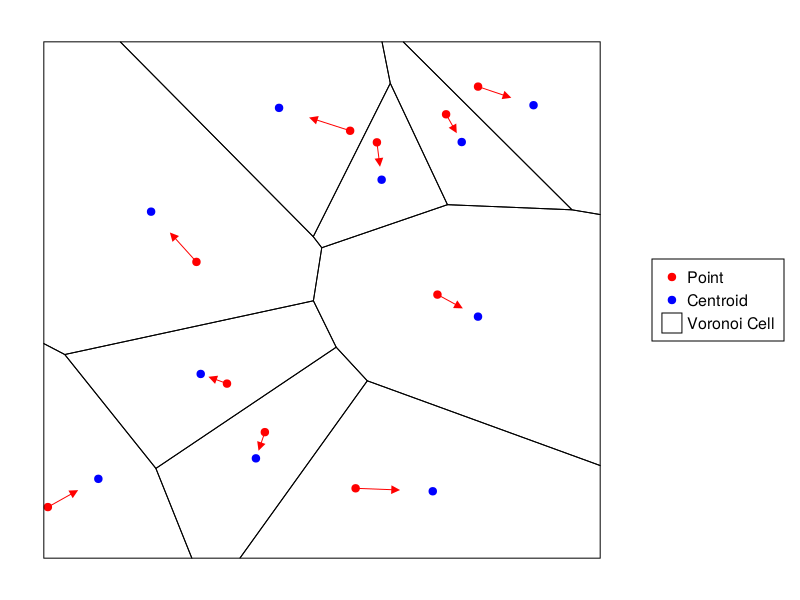

In [6]:
# Now we want to relax each point. We do this by moving each point some fraction of the way to the centroid of the cell

a = 0.5 # Fraction of the way to move
point_directions = a * (centroids .- points)

# Move the points
new_points = points .+ point_directions

# Show the movement
fig, ax, _ = plot(points, centroids, polys)

arrows!(ax, points, point_directions, color=:red, strokewidth=1)

fig

In [7]:
# Lets make the points an observable so we can redraw the plot every time we move the points
O_points = Observable(points)
O_centroids = Observable(centroids)
O_polys = Observable.(polys)

# Now simply plot the points and centroids while they are observable
fig, ax, _ = plot(O_points, O_centroids, O_polys)

lerp_size = 0.1
steps = 100
fps = 10
#Now we can loop over some relaxation steps and update the values in the observables


record(fig, "voronoi_relaxation.gif", 1:steps; framerate=fps) do frame
    # Update the points
    O_points.val = O_points.val .+ lerp_size * (O_centroids.val .- O_points.val)

    # Update the tesselation
    new_tess = voronoicells(O_points.val, bbox)
    new_tess.Cells
    # # Update the centroids and polygons
    O_centroids.val = centroid.(new_tess.Cells)

    for i in eachindex(O_polys)
        O_polys[i].val = Polygon(new_tess.Cells[i])
    end
    notify(O_points) # Redraw points
    notify(O_centroids) # Redraw centroids
end


"voronoi_relaxation.gif"

![](voronoi_relaxation.gif)

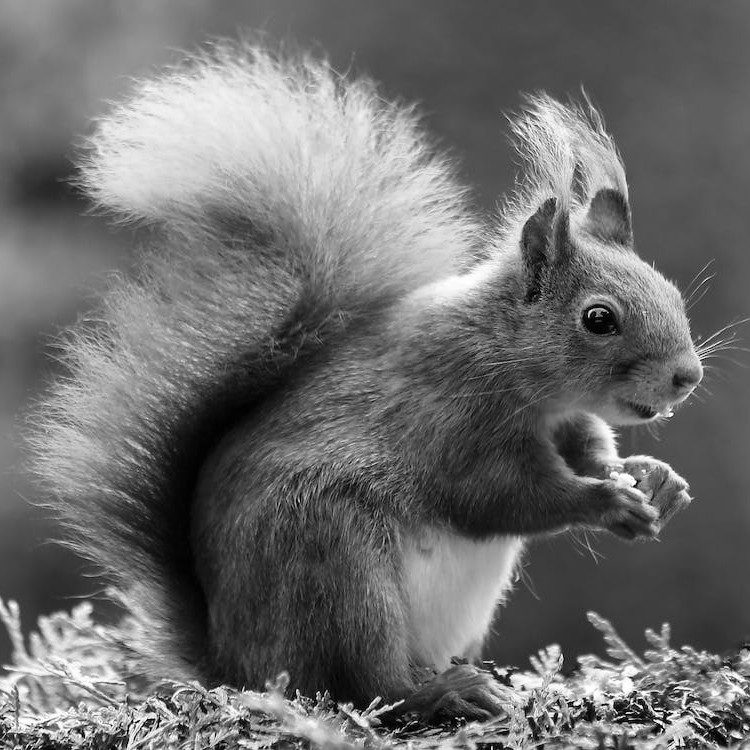

In [8]:
# Now we can load the image and convert to grayscale
img = Gray.(load("squirrel.jpg"))
img_data = rotr90(Float64.(img))

# Show image
img

In [61]:
# With the data, let's create a 2D grid of points. For simplicity, we will start with a regular grid
H, W = size(img)
N_points = 1000
dx = W / floor(Int, sqrt(N_points))
dy = H / floor(Int, sqrt(N_points))

P = [ Point2(x,y) for x in 0:dx:W, y in 0:dy:H ]

# Crop and normalize the points
P = map(p -> p .+ Point2(dx/2, dy/2), P[1:end-1, 1:end-1])[:];

# Create a bounding box for the image
img_bbox = Rectangle(Point2(0,0), Point2(W,H))

# Tesselate the points
img_tess = voronoicells(P, img_bbox)

Tessellation{Point2{Float64}}(Point2{Float64}[[12.096774193548388, 12.096774193548388], [36.29032258064517, 12.096774193548388], [60.483870967741936, 12.096774193548388], [84.6774193548387, 12.096774193548388], [108.87096774193549, 12.096774193548388], [133.06451612903226, 12.096774193548388], [157.25806451612902, 12.096774193548388], [181.4516129032258, 12.096774193548388], [205.6451612903226, 12.096774193548388], [229.83870967741936, 12.096774193548388]  …  [520.1612903225806, 737.9032258064516], [544.3548387096774, 737.9032258064516], [568.5483870967743, 737.9032258064516], [592.741935483871, 737.9032258064516], [616.9354838709678, 737.9032258064516], [641.1290322580645, 737.9032258064516], [665.3225806451613, 737.9032258064516], [689.516129032258, 737.9032258064516], [713.7096774193549, 737.9032258064516], [737.9032258064516, 737.9032258064516]], Rectangle{Point2{Float64}}([0.0, 0.0], [750.0, 750.0]), Vector{Point2{Float64}}[[[0.0, 24.193548387096744], [0.0, 0.0], [24.1935483870967

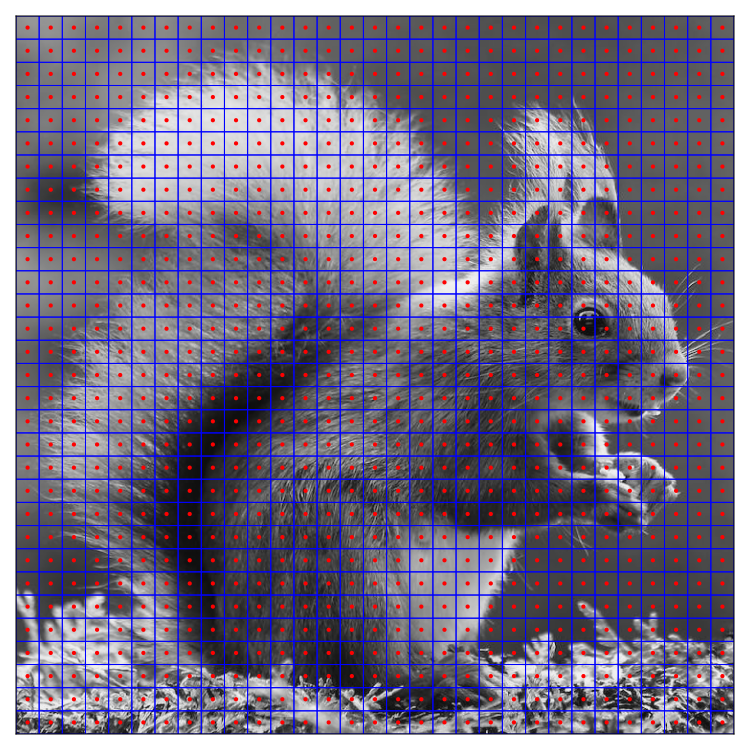

In [62]:
fig = Figure(resolution=(W,H))
ax = Makie.Axis(fig[1,1], aspect = DataAspect())
hidedecorations!(ax)

# Get polys
img_polys = Polygon.(img_tess.Cells)

img_plot = image!(ax, img_data, colormap=:grays)
scat_plot = scatter!(ax, P, color=:red, markersize=6)
poly_plot = poly!.(Ref(ax), img_polys, color=:transparent, strokewidth=1, strokecolor=:blue)

fig

In [11]:
function triangulate_poly(polygon)
    tris = []
    p0 = polygon[1]
    for i in 2:length(polygon)-1
        p1 = polygon[i]
        p2 = polygon[i+1]
        push!(tris, [p0, p1, p2])
    end
    return tris
end

function orientation(A, B, C)
    @inbounds AB = [B[1] - A[1], B[2] - A[2]]
    @inbounds AC = [C[1] - A[1], C[2] - A[2]]

    @inbounds det = AB[1] * AC[2] - AB[2] * AC[1]
    return sign(det)
end

function intris(p, tris)
    A, B, C = tris
    turns = orientation(A, B, p) + orientation(B, C, p) + orientation(C, A, p)
    return abs(turns) == 3
end

function inpoly(p, poly)
    tris = triangulate_poly(poly)

    for tri in tris
        if intris(p, tri)
            return true
        end
    end
    return false
end

inpoly (generic function with 1 method)

In [66]:
# Now we can check which polygon each pixel belongs to
point_poly_idx = zeros(Int, size(img_data))

last_poly_idx = 1

prog = Progress(prod(size(img_data)))
Threads.@threads for I in CartesianIndices(img_data)
    next!(prog)
    p = Point2(I[1], I[2])

    if inpoly(p, img_tess.Cells[last_poly_idx])
        point_poly_idx[I] = last_poly_idx
        continue
    end

    for (i, poly) in enumerate(img_tess.Cells)
        if inpoly(p, poly)
            point_poly_idx[I] = i
            last_poly_idx = i
            break
        end
    end
end
finish!(prog)

Progress:   0%|                                         |  ETA: 10:15:09

Progress:   2%|▊                                        |  ETA: 0:00:13

Progress:   3%|█▍                                       |  ETA: 0:00:11

Progress:   5%|█▉                                       |  ETA: 0:00:12

Progress:   5%|██▏                                      |  ETA: 0:00:13

Progress:   6%|██▍                                      |  ETA: 0:00:13

Progress:   7%|██▊                                      |  ETA: 0:00:14

Progress:   7%|██▉                                      |  ETA: 0:00:15

Progress:   8%|███▏                                     |  ETA: 0:00:15

Progress:   8%|███▎                                     |  ETA: 0:00:15

Progress:   8%|███▌                                     |  ETA: 0:00:16

Progress:   9%|███▋                                     |  ETA: 0:00:16

Progress:   9%|███▊                                     |  ETA: 0:00:17

Progress:  10%|████                                     |  ETA: 0:00:17

Progress:  10%|████▏                                    |  ETA: 0:00:18

Progress:  10%|████▎                                    |  ETA: 0:00:18

Progress:  11%|████▍                                    |  ETA: 0:00:18

Progress:  11%|████▌                                    |  ETA: 0:00:19

Progress:  11%|████▋                                    |  ETA: 0:00:19

Progress:  12%|████▊                                    |  ETA: 0:00:19

Progress:  12%|████▉                                    |  ETA: 0:00:20

Progress:  12%|█████                                    |  ETA: 0:00:20

Progress:  13%|█████▏                                   |  ETA: 0:00:20

Progress:  13%|█████▎                                   |  ETA: 0:00:21

Progress:  13%|█████▍                                   |  ETA: 0:00:21

Progress:  13%|█████▌                                   |  ETA: 0:00:21

Progress:  14%|█████▋                                   |  ETA: 0:00:22

Progress:  14%|█████▋                                   |  ETA: 0:00:22

Progress:  14%|█████▊                                   |  ETA: 0:00:22

Progress:  14%|█████▉                                   |  ETA: 0:00:22

Progress:  15%|██████                                   |  ETA: 0:00:23

Progress:  15%|██████▏                                  |  ETA: 0:00:23

Progress:  15%|██████▏                                  |  ETA: 0:00:23

Progress:  15%|██████▎                                  |  ETA: 0:00:24

Progress:  16%|██████▍                                  |  ETA: 0:00:24

Progress:  16%|██████▌                                  |  ETA: 0:00:24

Progress:  16%|██████▋                                  |  ETA: 0:00:24

Progress:  16%|██████▋                                  |  ETA: 0:00:24

Progress:  16%|██████▊                                  |  ETA: 0:00:25

Progress:  17%|██████▉                                  |  ETA: 0:00:25

Progress:  17%|██████▉                                  |  ETA: 0:00:25

Progress:  17%|███████                                  |  ETA: 0:00:25

Progress:  17%|███████▏                                 |  ETA: 0:00:26

Progress:  17%|███████▏                                 |  ETA: 0:00:26